In [1]:
import scvelo as scv
import scanpy as sc
import scFates as scf
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import palantir
from cuml import UMAP
%matplotlib inline
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo',figsize=(5,5),dpi_save=600)

In [2]:
scf.tl.test_association

<function scFates.tools.test_association.test_association(adata: anndata._core.anndata.AnnData, n_map: int = 1, n_jobs: int = 1, spline_df: int = 5, fdr_cut: float = 0.0001, A_cut: int = 1, st_cut: float = 0.8, reapply_filters: bool = False, plot: bool = False, root=None, leaves=None, copy: bool = False, layer: Union[str, NoneType] = None)>

In [3]:
from caching_wrappers import * 
name="Bif_Gut_glia_SC"

In [4]:
import pandas as pd
auc=pd.read_csv("scenic/output/auc_mtx_mm10.csv",index_col=0)

In [5]:
def reprocess(adata,root,leaves):
    
    path=scf.tools.getpath(adata,root_milestone=root,milestones=leaves)
    path=path[~path.index.duplicated(keep='first')]
    import numpy as np

    colkeep=list(map(lambda m: adata.uns["milestones_colors"][np.argwhere(adata.obs.milestones.cat.categories==m)[0][0]],
         path.milestones.unique()))
    
    adata=adata[path.index,]
    dm_res = palantir.utils.run_diffusion_maps(auc.loc[path.index,:],knn=100)
    ms_data = palantir.utils.determine_multiscale_space(dm_res)
    umap = UMAP(n_components = 2,n_neighbors=150,min_dist=.4,n_epochs=2000,random_state=1)
    emb = umap.fit_transform(ms_data.values)
    plt.figure(figsize=(10,10))
    plt.scatter(emb[:,0],emb[:,1],c=adata.obs.t[ms_data.index],s=10,cmap="viridis")
    plt.axis("off")
    plt.tight_layout()
    adata.obsm["X_umap2"] = adata.obsm["X_umap"]
    adata.obsm["X_umap"] = emb
    
    del adata.uns
    
    adata.obs["old_milestones"] = adata.obs["milestones"]
    adata.obs.old_milestones=adata.obs.old_milestones.cat.reorder_categories(path.milestones.unique())
    adata.uns["old_milestones_colors"] = colkeep
    
    return adata

In [6]:
adata=sc.read("adata_tree_fpm.h5ad")

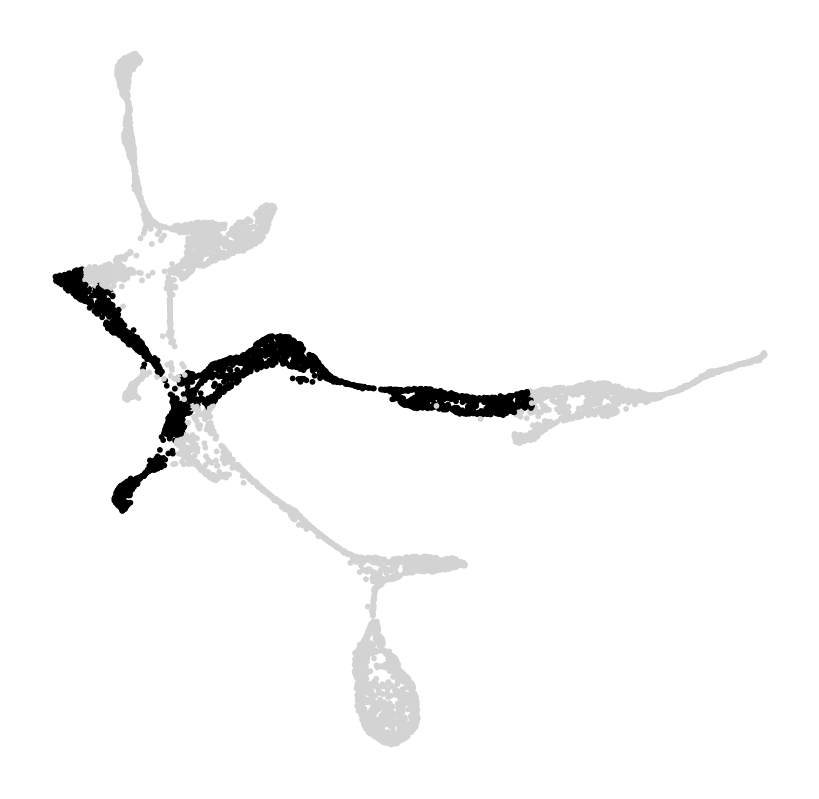

In [7]:
path=scf.tools.getpath(adata,"ecaNCC",["imSC","Gut_glia"])
path=path[~path.index.duplicated(keep='first')]
adata.obs["sel"]=adata.obs_names.isin(path.index)
adata.obs["sel"]=adata.obs["sel"].astype("category")
sc.pl.umap(adata,color="sel",palette=["lightgrey","black"],frameon=False,legend_loc="none",title="",
           save="-Bif_Gut_glia_SC.png")

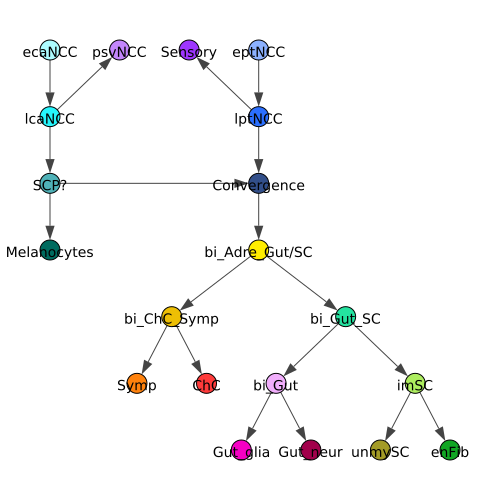

In [8]:
scf.pl.milestones(adata,roots=["ecaNCC","eptNCC","Sensory","psvNCC"])

Determing nearest neighbor graph...


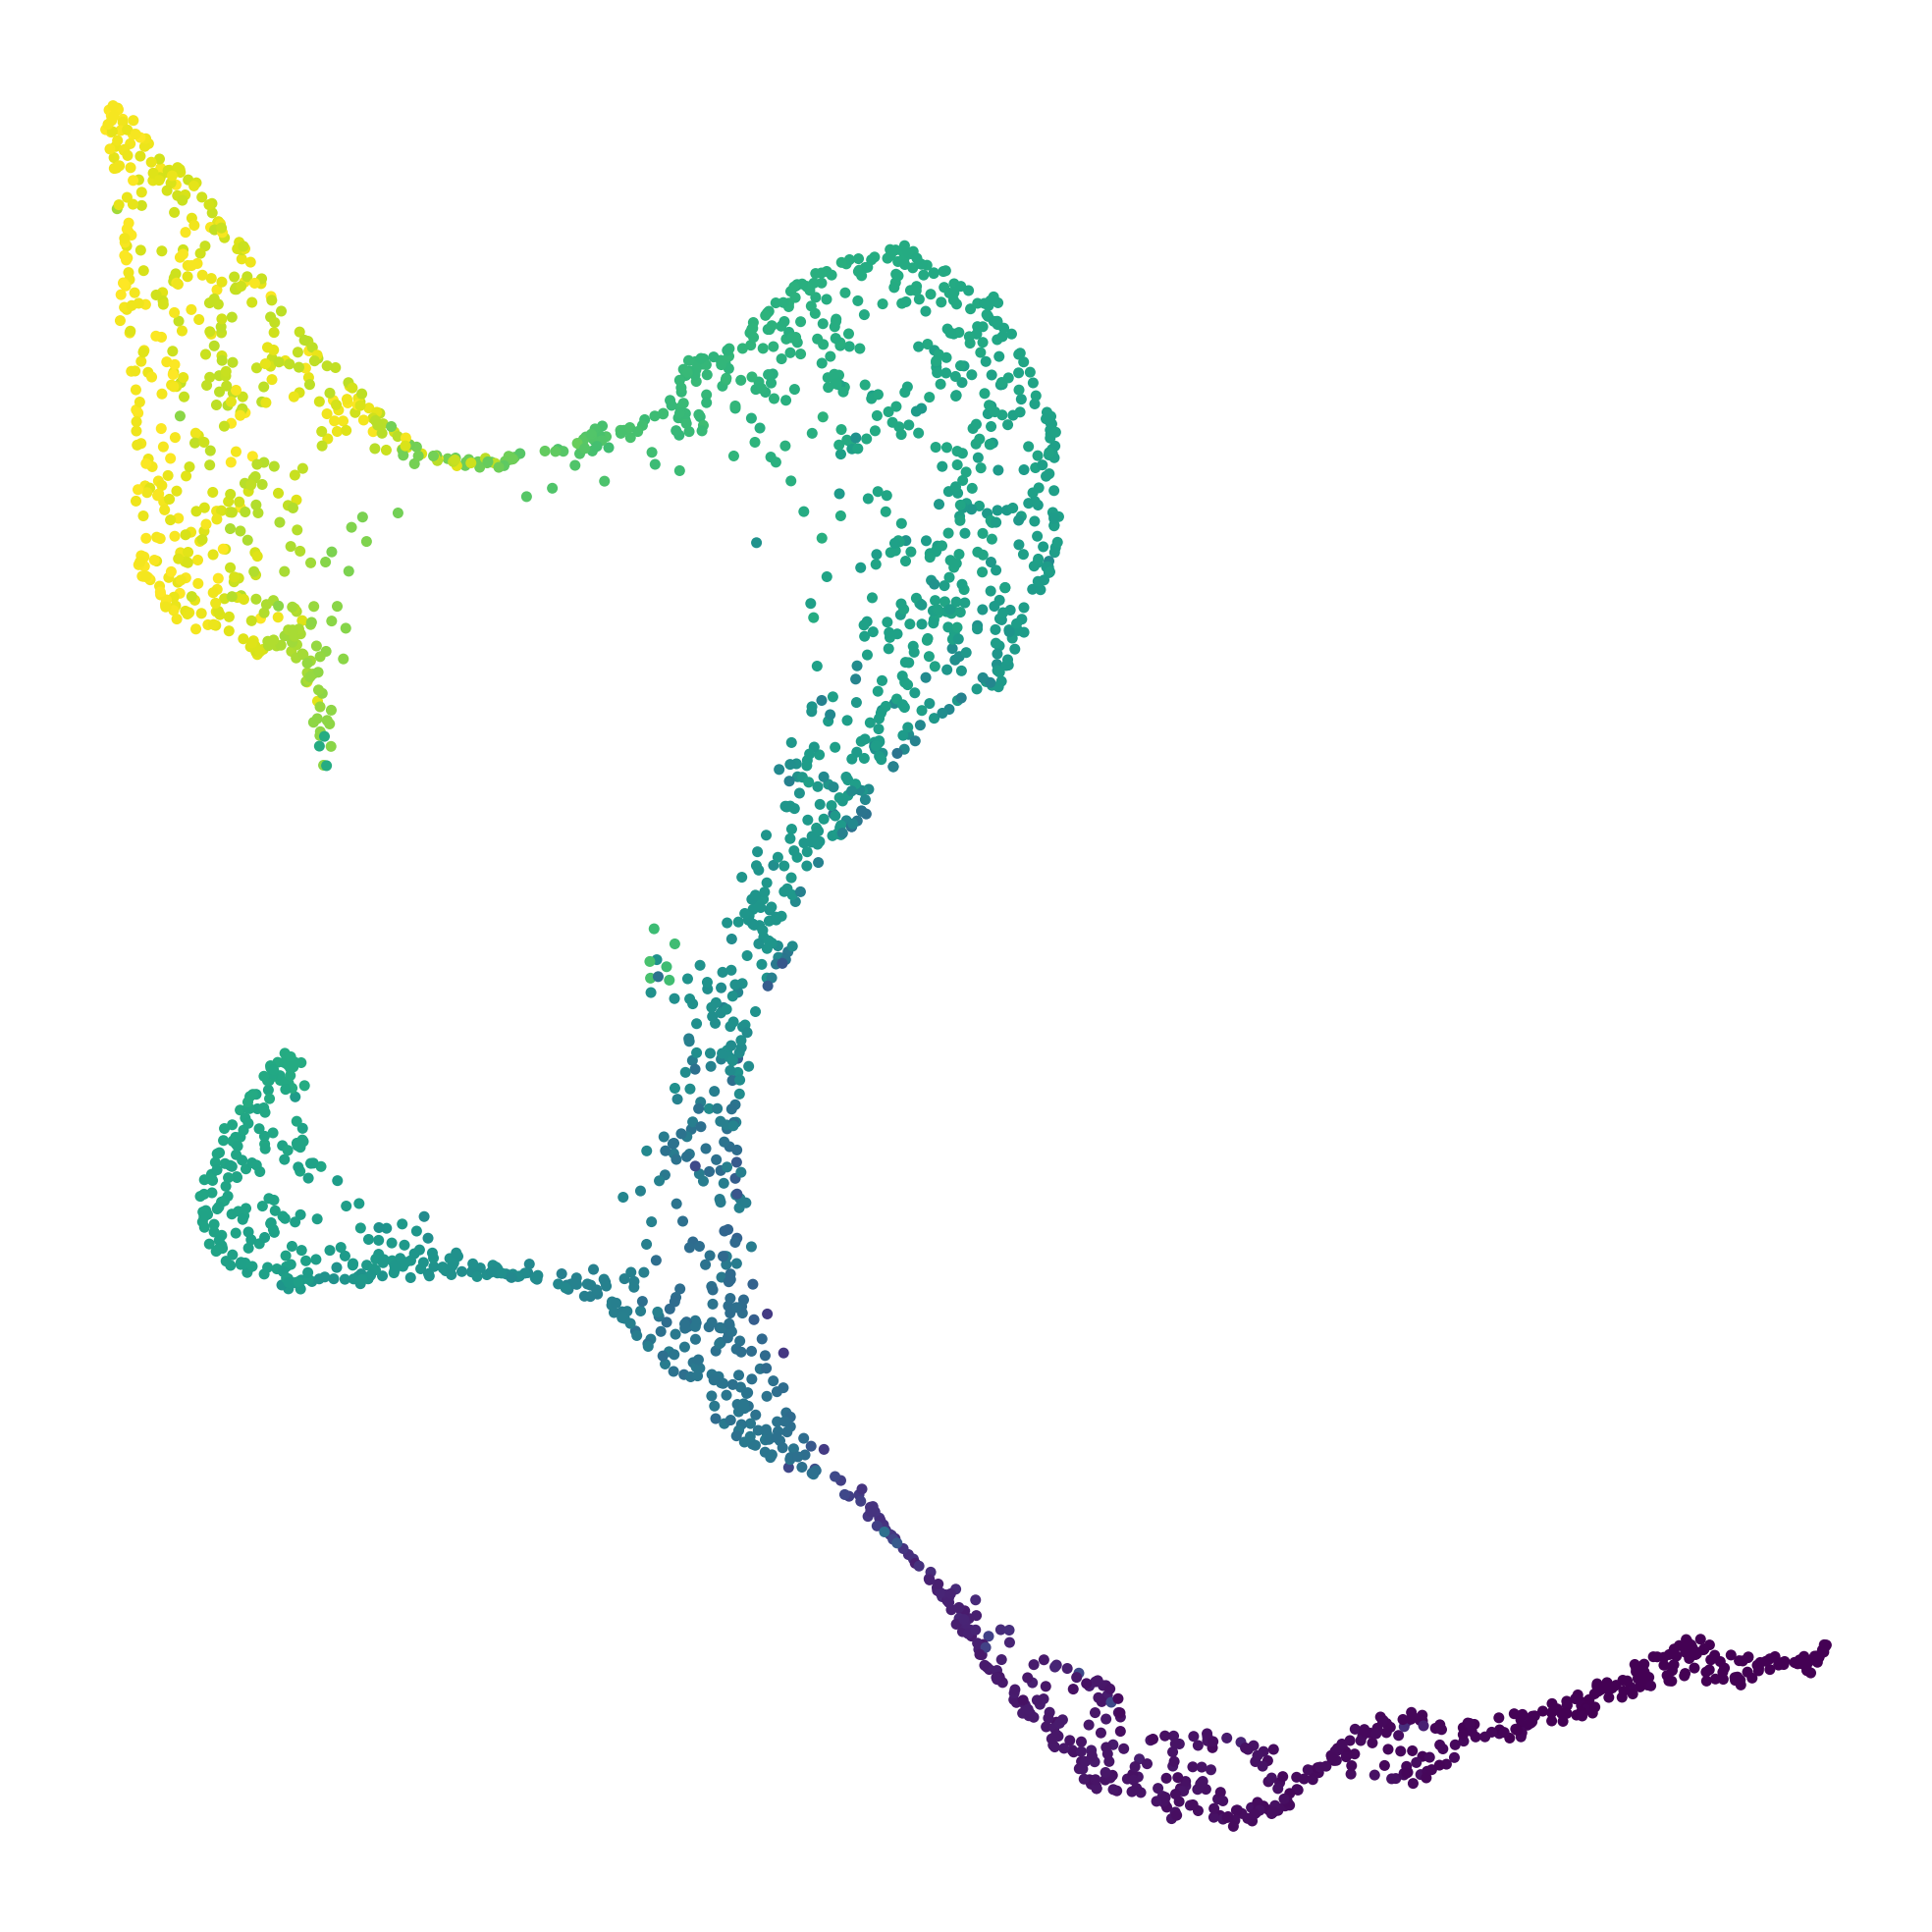

In [9]:
adata=reprocess(adata,"ecaNCC",["imSC","Gut_glia"])

In [10]:
c.tl.tree(adata,Nodes=500,ppt_err_cut=0.01,
            use_rep="diffusion",ppt_sigma = 0.05,ppt_lambda=100,
            method="ppt",device="gpu",seed=1,fname=name+'-tree')

Loading data from: `Bif_Gut_glia_SC-tree.pickle`.


    tree cleaned --> removed 68 principal points


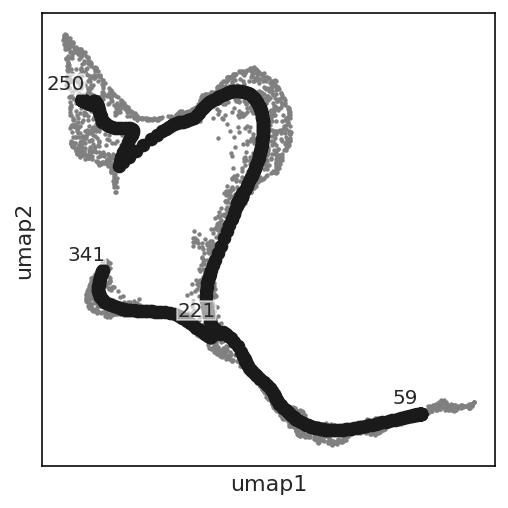

In [11]:
%matplotlib inline
scf.tl.cleanup(adata,minbranchlength=50)
scf.pl.tree(adata)

In [12]:
scf.tl.root(adata,59)

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)


In [13]:
scf.tl.pseudotime(adata)

projecting cells onto the principal tree
    finished (0:00:01) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'pseudotime_list', list of cell projection from all mappings (adata.uns)


In [14]:
adata

AnnData object with n_obs × n_vars = 2463 × 20074
    obs: 'devtime', 'plates', 'locations', 'leiden', 'S_score', 'G2M_score', 'phase', 'cell_cycle', 'NCC', 'Symp', 'ChC', 'Sensory', 'Gut_glia', 'Gut_neuron', 'Melanocyte', 'SC', 'enFib', 'assignments', 'Enteric_Adrenal', 'NCC_Glia', 'NCC_Glia_module', 'SCP_module', 'NCC_module', 't', 'seg', 'edge', 'milestones', 'NCC_sel', 'cytoTRACE', 'sel', 'old_milestones'
    uns: 'old_milestones_colors', 'tree', 'pseudotime_list'
    obsm: 'X_UMAP3d', 'X_diffusion', 'X_umap', 'X_umap2'

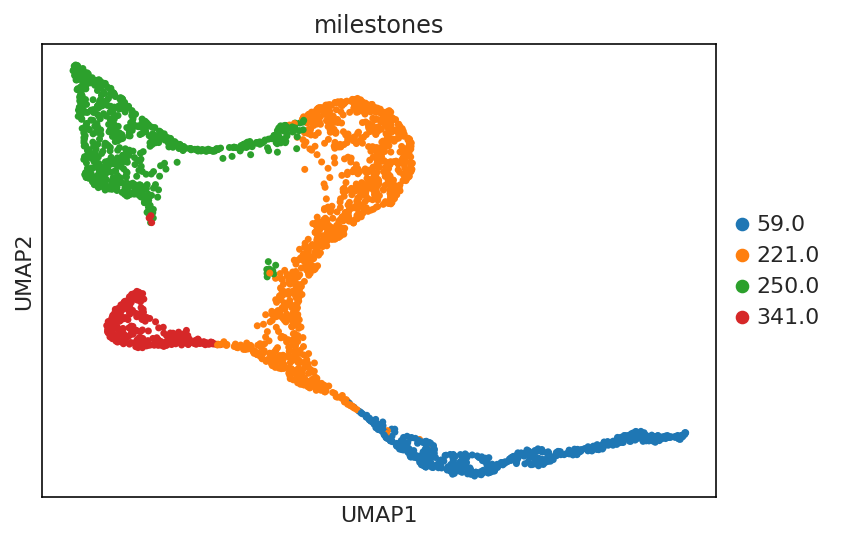

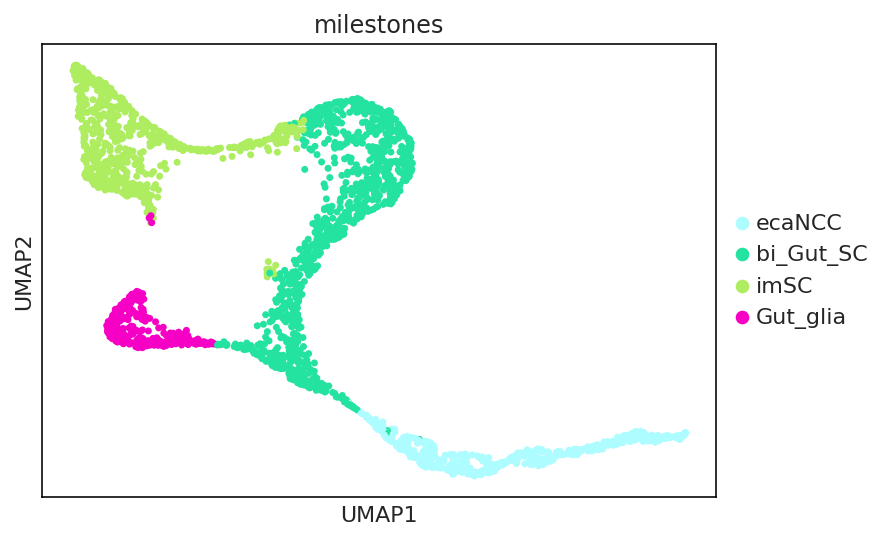

In [15]:
sc.pl.umap(adata,color="milestones")

mil=["ecaNCC","bi_Gut_SC","imSC","Gut_glia"]
adata.obs.milestones=adata.obs.milestones.cat.rename_categories(mil)
dct=dict(zip(adata.obs.old_milestones.cat.categories,adata.uns["old_milestones_colors"]))
adata.uns["milestones_colors"]=[dct[idx] for idx in adata.obs.milestones.cat.categories]
sc.pl.umap(adata,color="milestones")

In [16]:
adata.uns["milestones_colors"][1]="#DCDCDC"

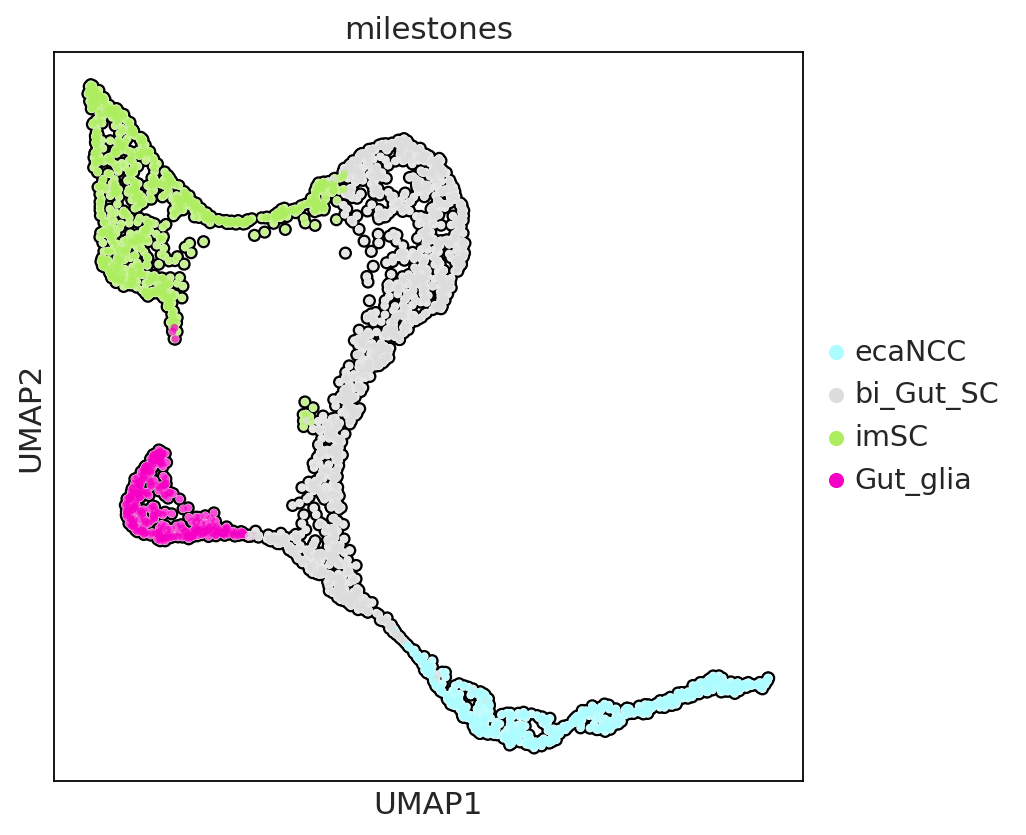

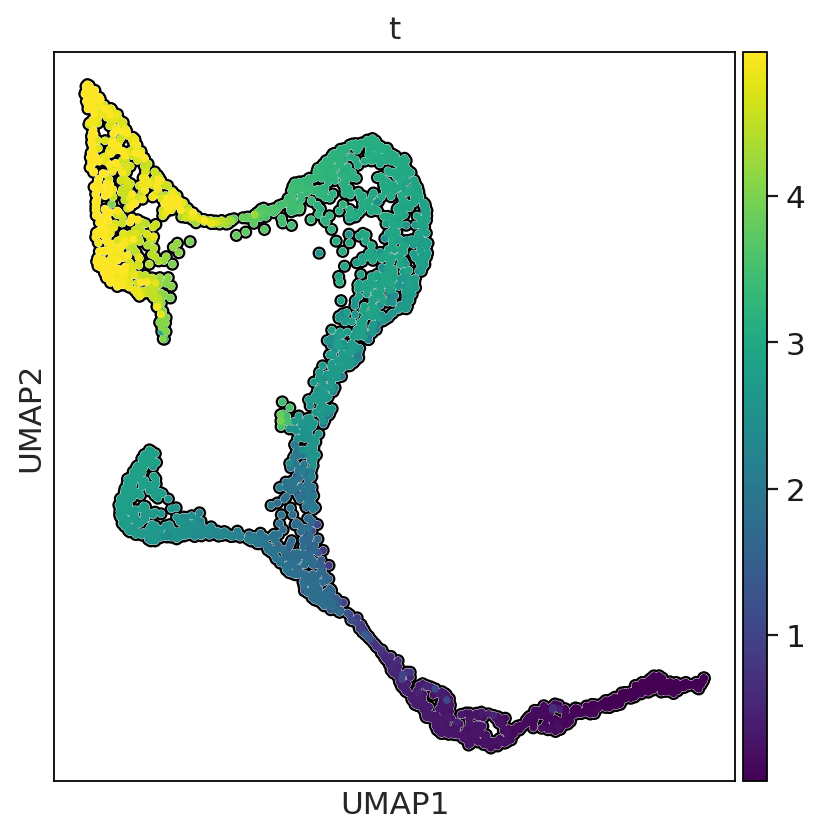

In [17]:
sc.set_figure_params(figsize=(6,6),dpi_save=600)
sc.pl.umap(adata,color="milestones",add_outline=True,save="milestones-Bif_Gut_glia_SC.png")
sc.pl.umap(adata,color="t",add_outline=True,color_map="viridis",alpha=1,save="pseudotime-Bif_Gut_glia_SC.png")

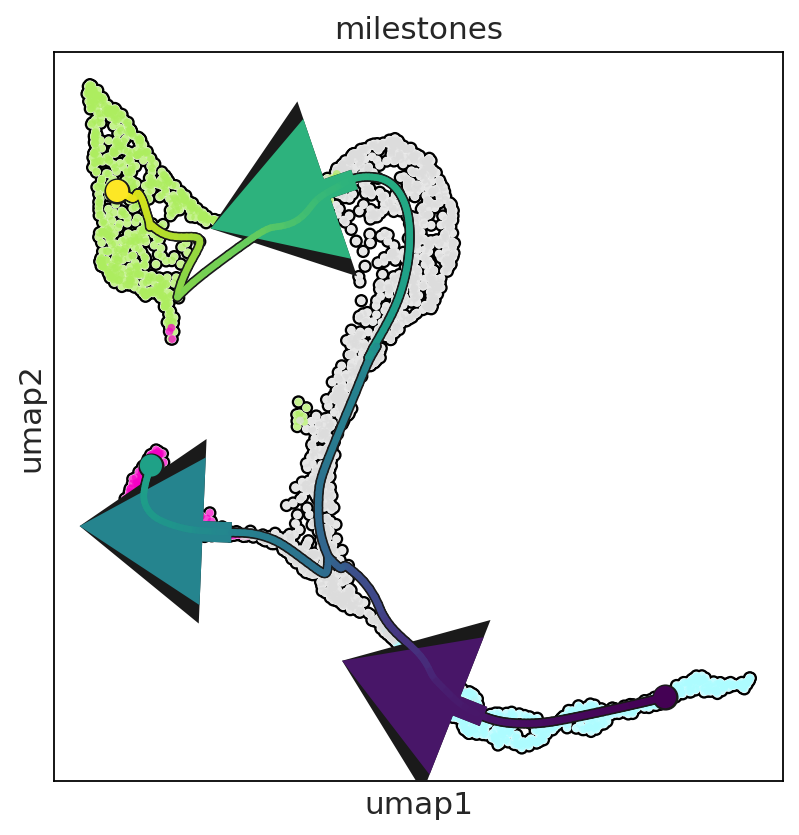

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sc.pl.umap(adata,color="milestones",show=False,legend_loc="none",add_outline=True,ax=ax,size=50)
scf.pl.trajectory(adata,arrows=True,scale_path=0.6,alpha_cells=0,ax=ax,
                  save="-Bif_Gut_glia_SC.png")

In [19]:
c.tl.test_association(adata,n_jobs=40,fname=name+'-test_association')

Loading data from: `Bif_Gut_glia_SC-test_association.pickle`.


In [20]:
import os.path
if os.path.isfile("temp/tl/"+name+"-fit.h5ad"):
    adata=sc.read("temp/tl/"+name+"-fit.h5ad")
else:
    scf.tl.fit(adata,n_jobs=40)
    adata.write("temp/tl/"+name+"-fit.h5ad")

In [21]:
root_mil="ecaNCC"
miles = ["Gut_glia","imSC"]

In [22]:
c.tl.test_fork(adata,root_milestone=root_mil,milestones=miles,n_jobs=40,rescale=True,
               fname=name+"-test_fork")

No cache found in `Bif_Gut_glia_SC-test_fork.pickle`, computing values.
testing fork
    mapping: 0
    differential expression: 100%|██████████| 5393/5393 [01:21<00:00, 66.22it/s]
    test for upregulation for each leave vs root
    leave imSC: 100%|██████████| 5393/5393 [00:08<00:00, 617.99it/s]
    finished (0:01:39) --> added 
    'ecaNCC->Gut_glia<>imSC/fork', DataFrame with fork test results (adata.uns)


In [23]:
scf.tl.branch_specific(adata,root_milestone=root_mil,milestones=miles,
                       effect_b1=.8,effect_b2=1.2)

    49 features found to be specific to leave Gut_glia
    75 features found to be specific to leave imSC
    finished --> updated 
    'ecaNCC->Gut_glia<>imSC/fork', DataFrame updated with additionnal 'branch' column (adata.uns)


In [24]:
scf.tl.activation(adata,root_milestone=root_mil,milestones=miles,n_jobs=20,pseudotime_offset=0.5,deriv_cut=0.2)

testing activation
    leave imSC: 100%|██████████| 75/75 [00:00<00:00, 90.99it/s]
    18 early and 31 late features specific to leave Gut_glia
    21 early and 54 late features specific to leave imSC
    finished (0:00:16) --> updated 
    'ecaNCC->Gut_glia<>imSC/fork', DataFrame updated with additionnal 'activation' and 'module' columns (adata.uns)


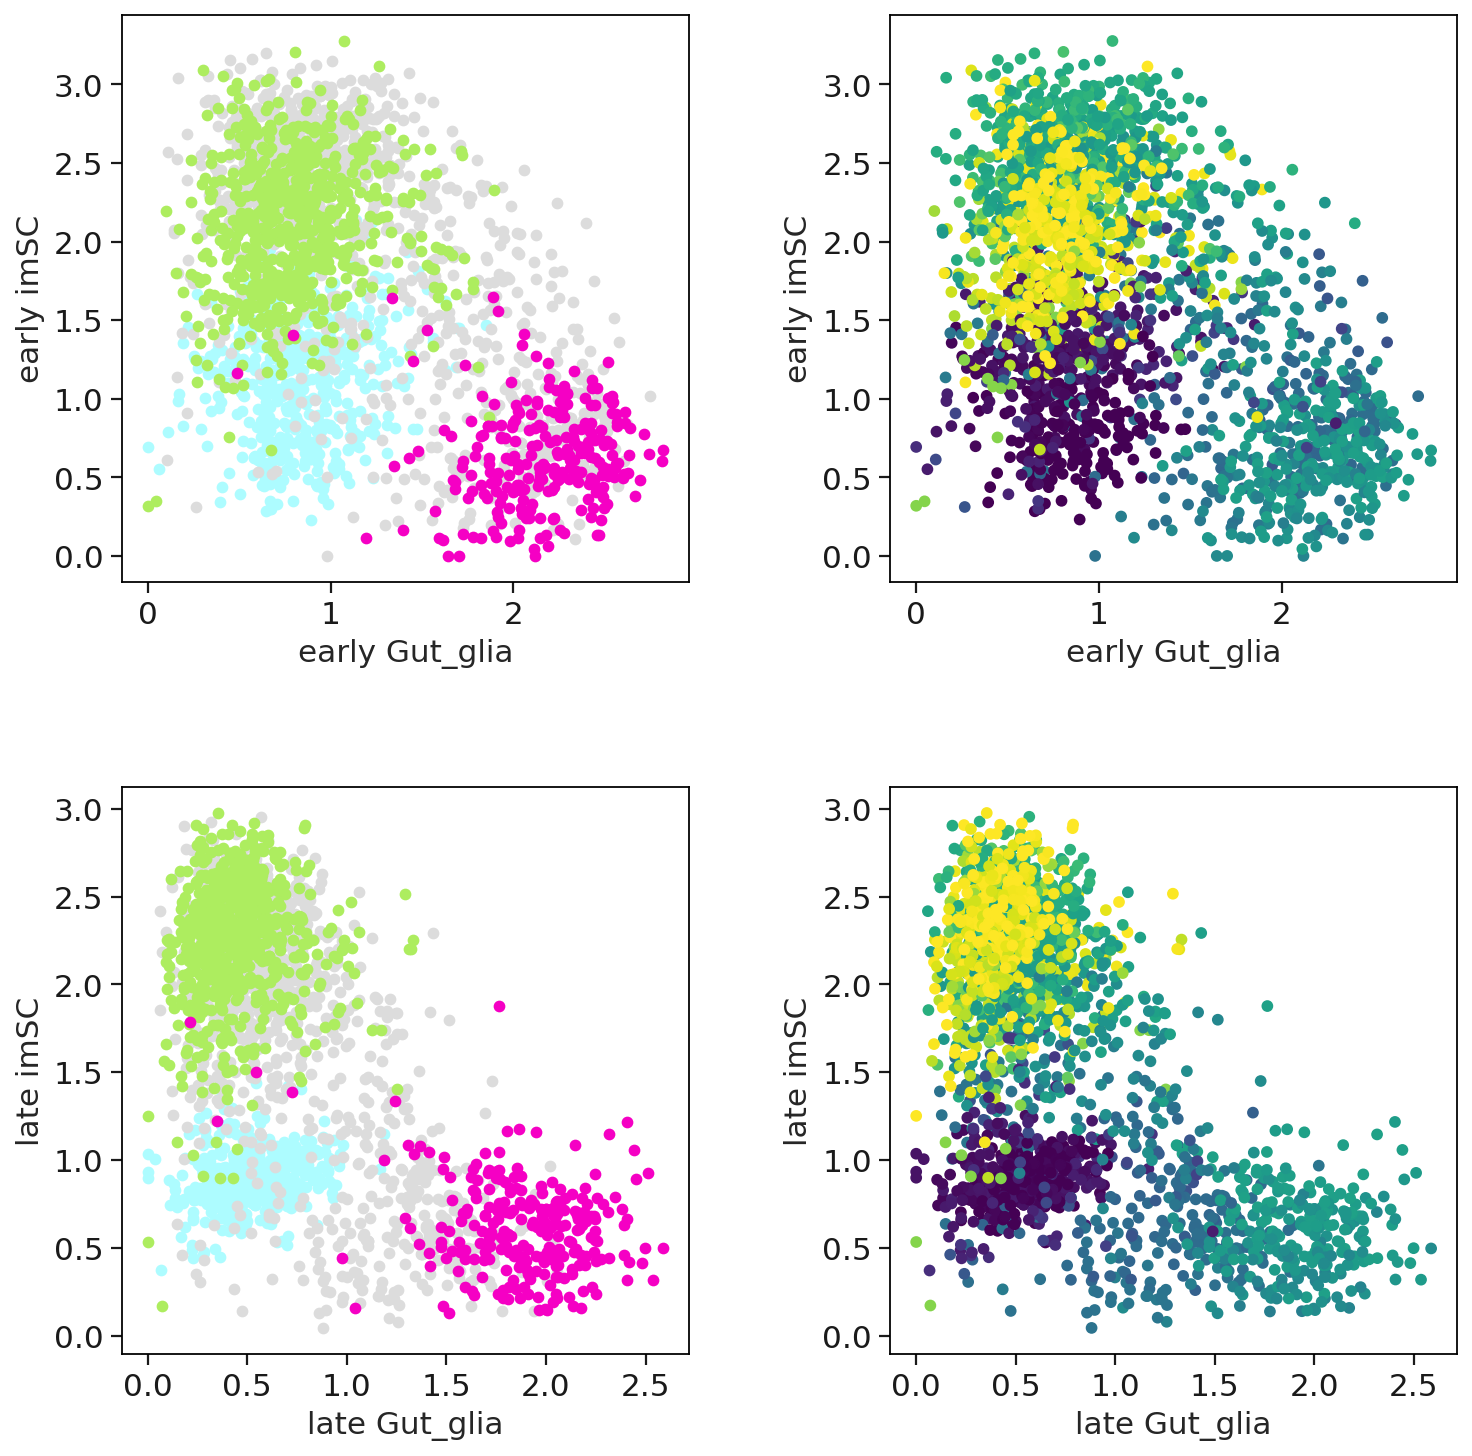

In [25]:
scf.pl.modules(adata,root_milestone=root_mil,milestones=miles,color="milestones",
               save="-Bif_Gut_glia_SC.png")

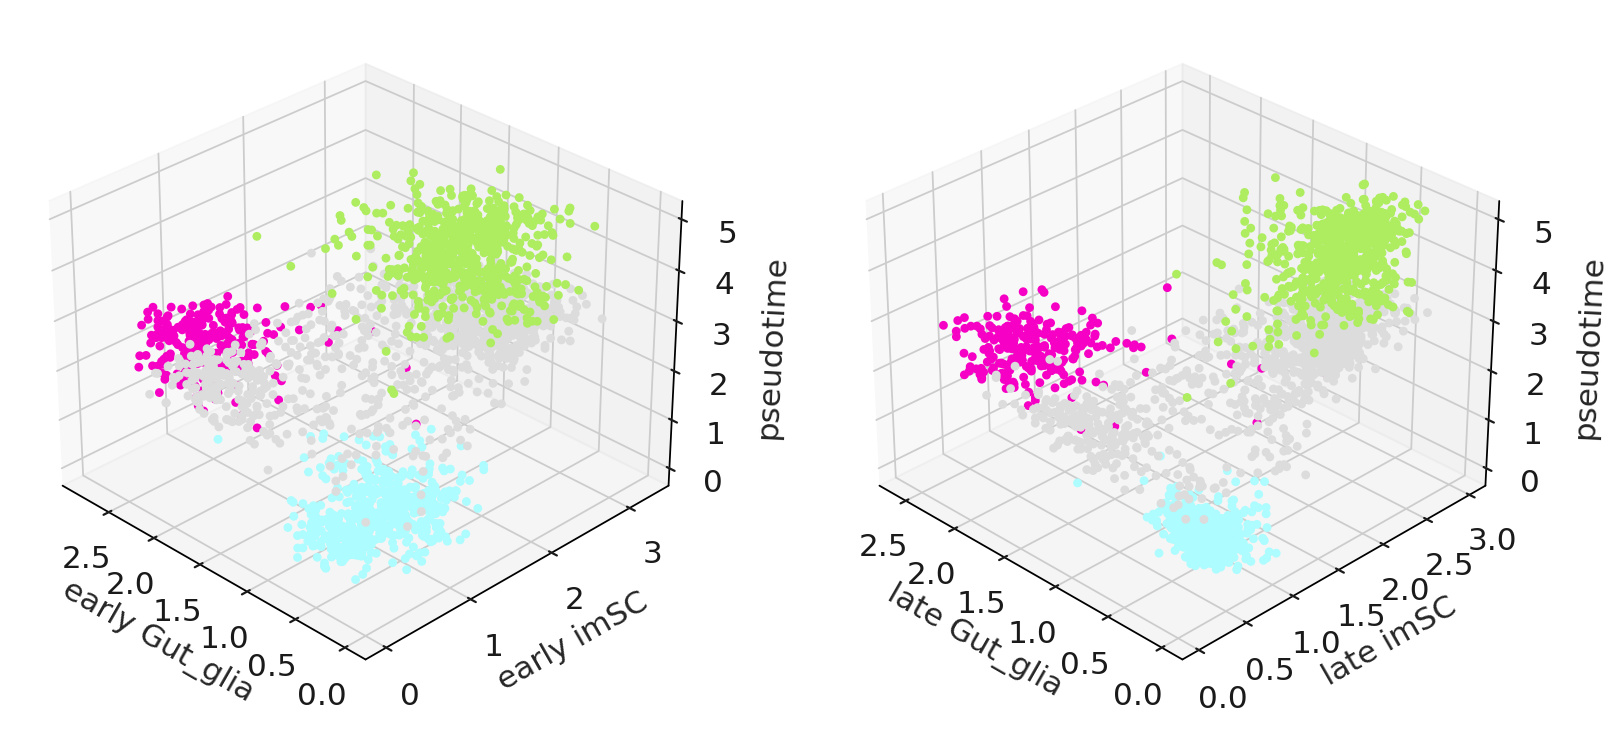

In [26]:
scf.pl.modules(adata,root_milestone=root_mil,milestones=miles,color="milestones",mode="3d")

In [27]:
df=adata.uns["ecaNCC->Gut_glia<>imSC"]["fork"]

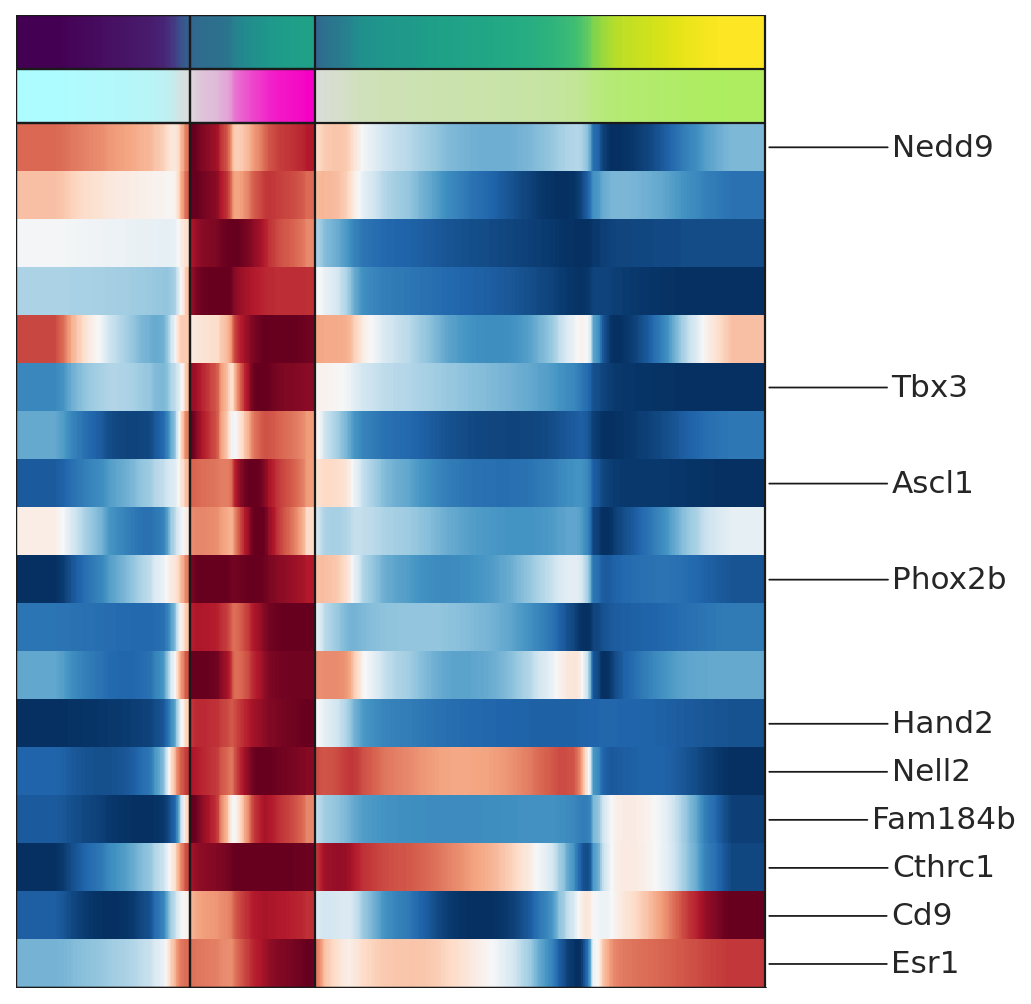

In [28]:
scf.pl.trends(adata,features=df.index[(df.module=="early") & (df.branch==miles[0])],
                    filter_complex=False,ordering="pearson",
                    save="-early_gut_glia.png")

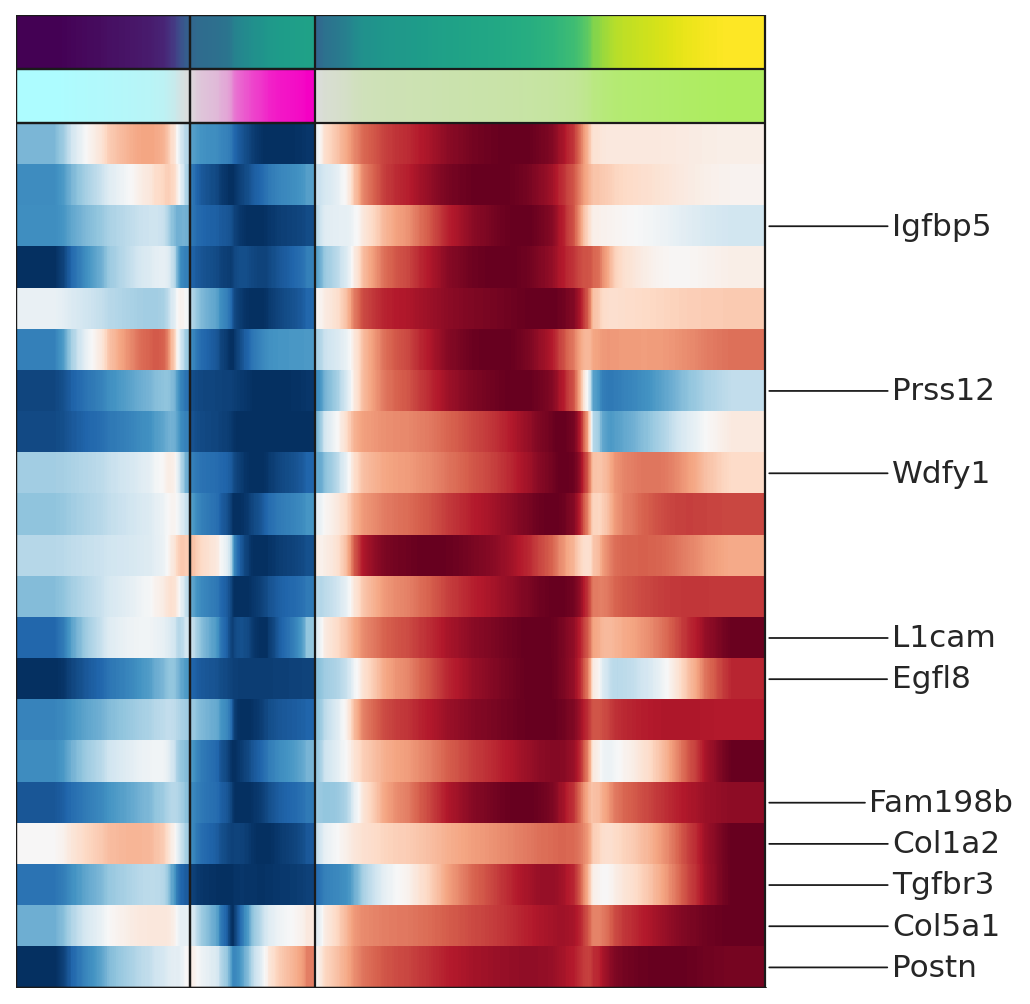

In [29]:
scf.pl.trends(adata,features=df.index[(df.module=="early") & (df.branch==miles[1])],
                    filter_complex=False,ordering="pearson",
                    save="-early_glia.png")

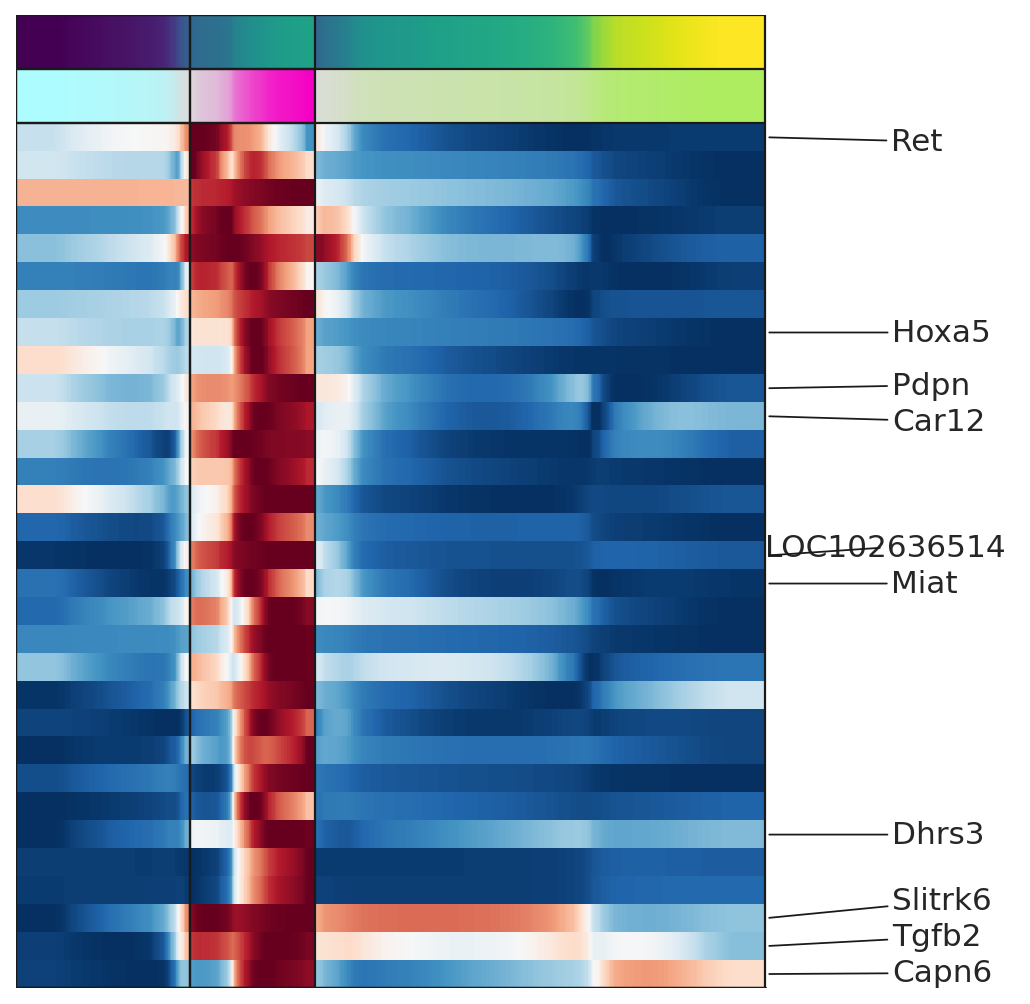

In [30]:
scf.pl.trends(adata,features=df.index[(df.module=="late") & (df.branch==miles[0])],
                    filter_complex=False,ordering="pearson",
                    save="-late_gut_glia.png")

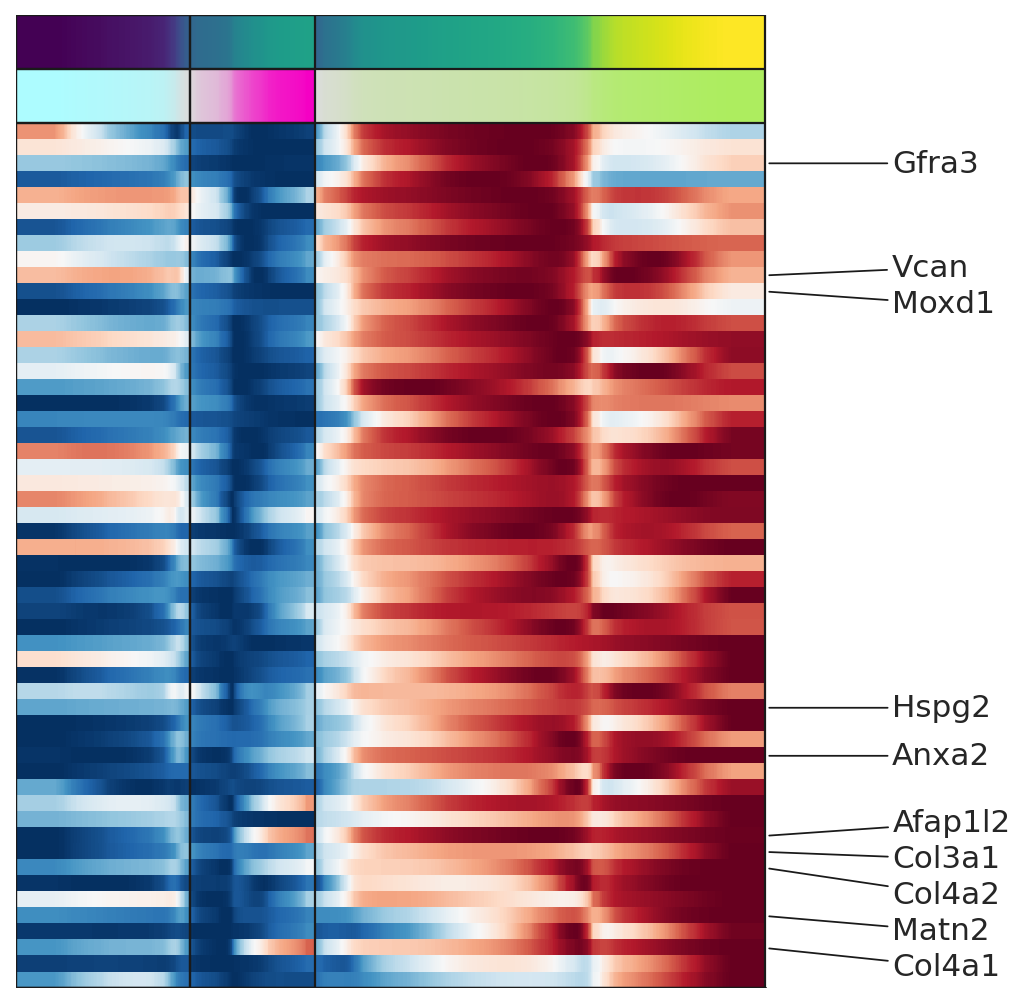

In [31]:
scf.pl.trends(adata,features=df.index[(df.module=="late") & (df.branch==miles[1])],
                    filter_complex=False,ordering="pearson",
                    save="-late_glia.png")

In [32]:
adata.uns['ecaNCC->Gut_glia<>imSC']['fork'].to_csv("ecaNCC->Gut_glia<>imSC.csv")

In [33]:
scf.tl.slide_cells(adata,root_milestone=root_mil,milestones=miles,win=150)

--> added 
    'ecaNCC->Gut_glia<>imSC/cell_freq', probability assignment of cells on 17 non intersecting windows (adata.uns)


In [34]:
scf.tl.slide_cors(adata,root_milestone=root_mil,milestones=miles)

--> added 
    'ecaNCC->Gut_glia<>imSC/corAB', gene-gene correlation modules (adata.uns)


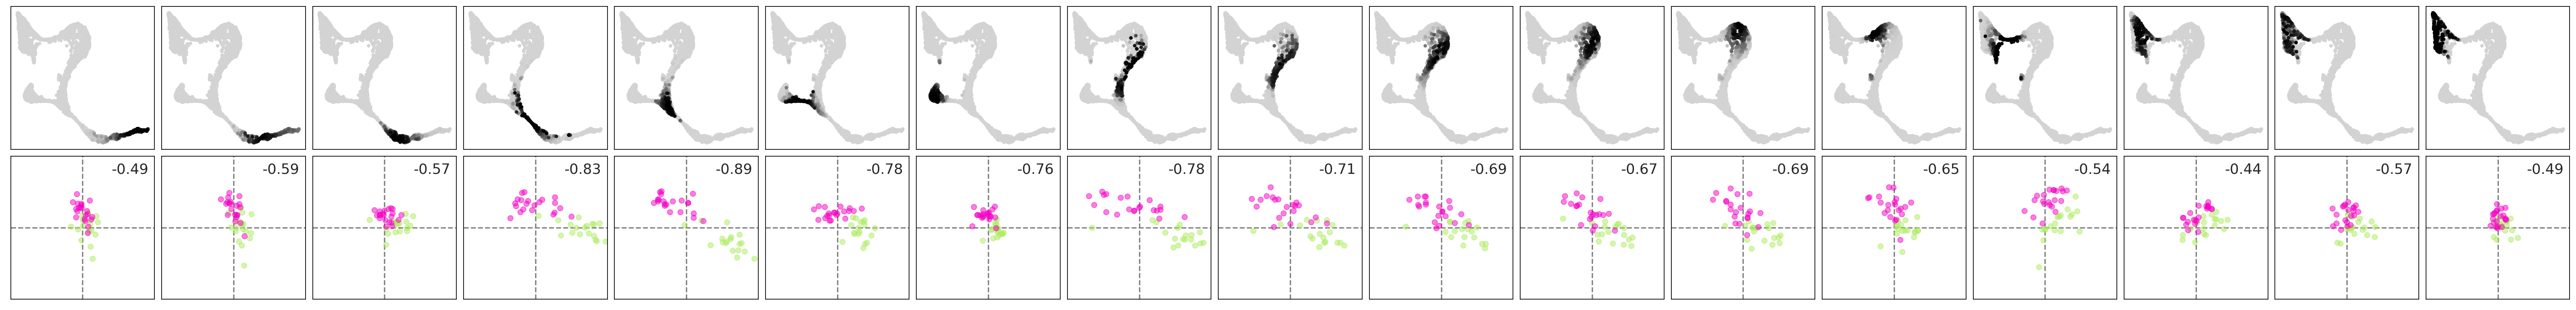

In [35]:
scf.pl.slide_cors(adata,root_milestone=root_mil,milestones=miles,
                 save="-Bif_Gut_glia_SC.png")

In [39]:
scf.tl.synchro_path(adata,root_milestone=root_mil,milestones=miles,w=100,loess_span=0.3)

computing local correlations
    finished (0:00:03) --> added 
    'ecaNCC->Gut_glia<>imSC/synchro', mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules (adata.uns)
    'inter_cor ecaNCC->Gut_glia<>imSC', loess fit of inter-module mean local gene-gene correlations prior to bifurcation (adata.obs)


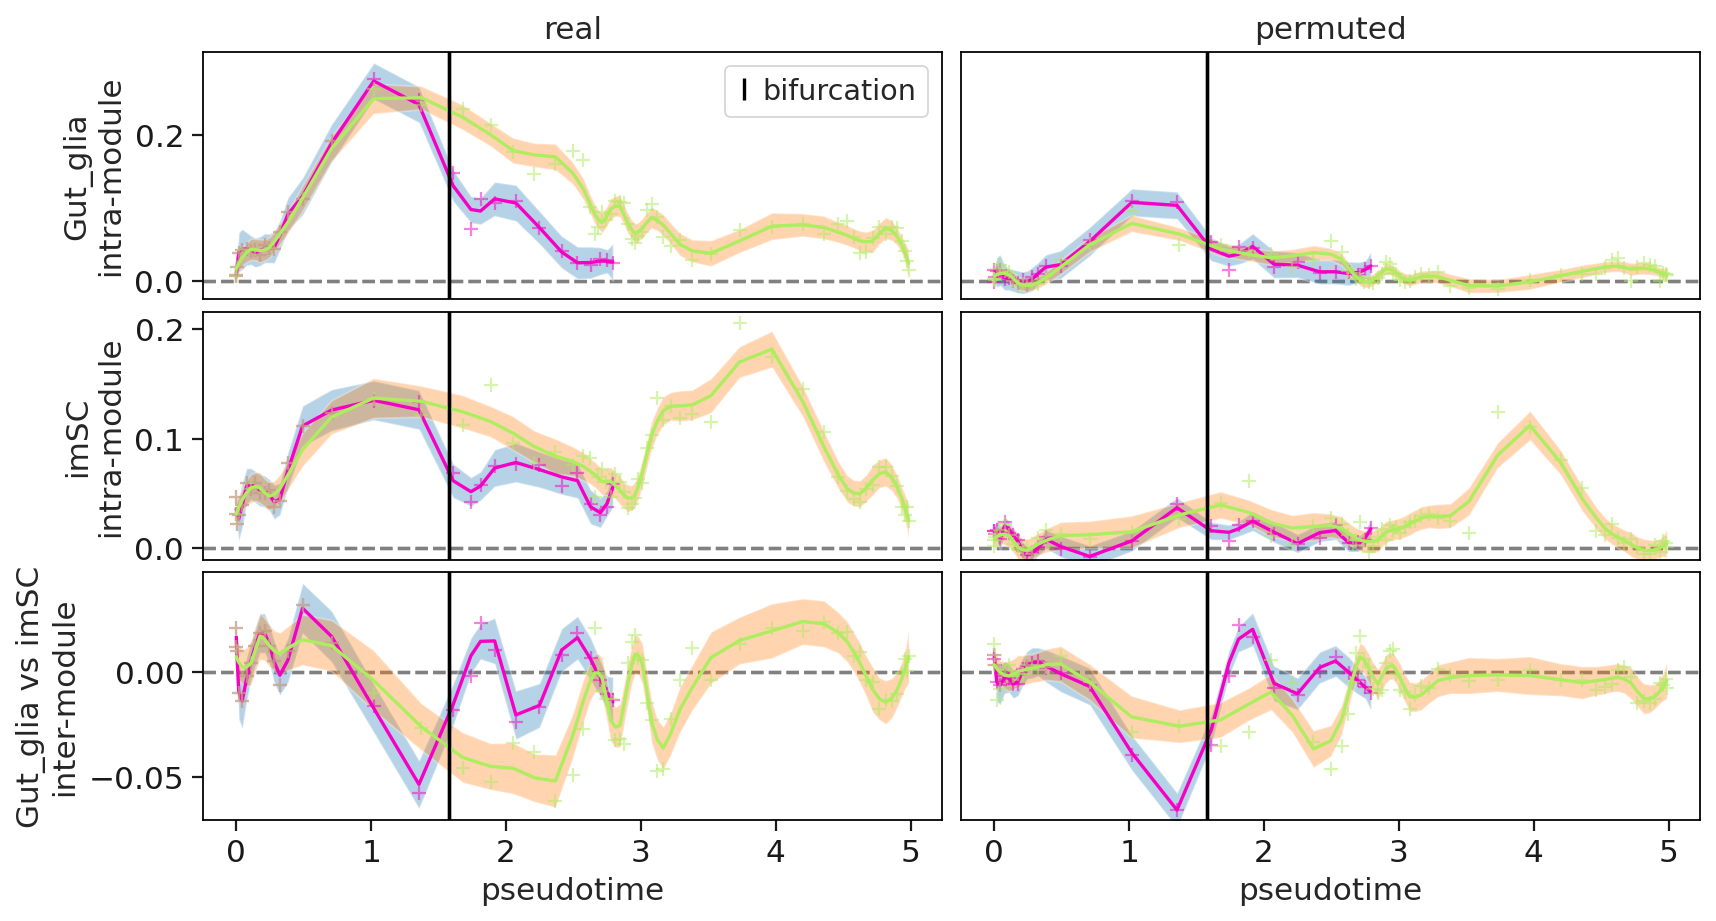

In [40]:
scf.pl.synchro_path(adata,root_milestone=root_mil,milestones=miles,
                   save="-Bif_Gut_glia_SC.png")

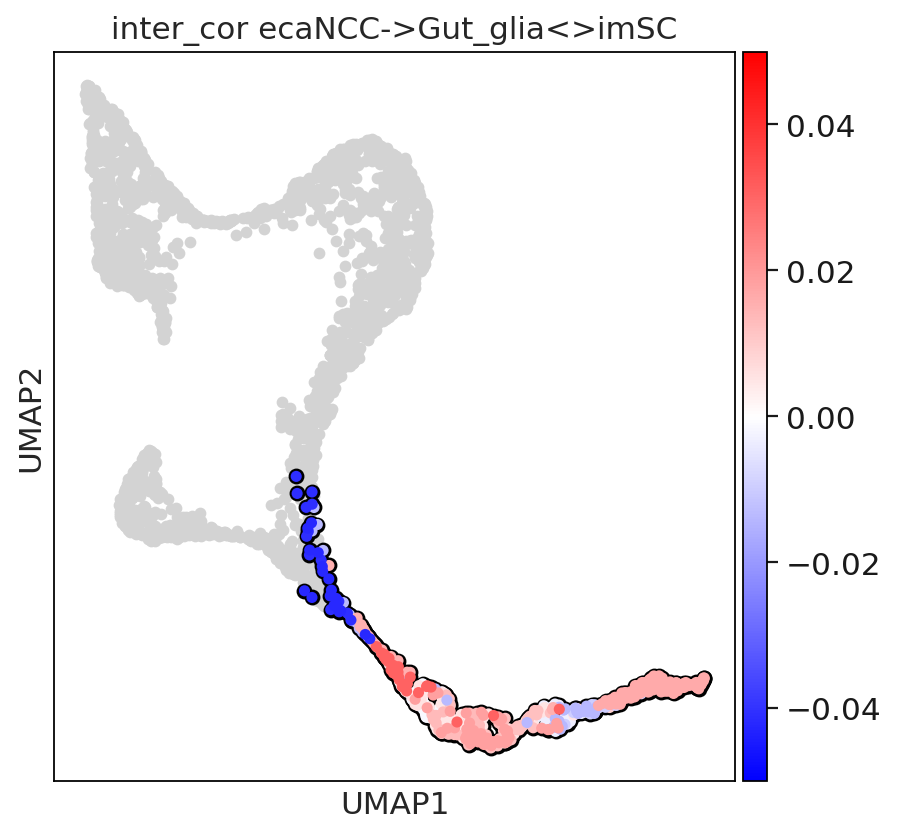

In [42]:
import matplotlib.pyplot as plt
import numpy as np
nm="inter_cor "+root_mil+"->"+miles[0]+"<>"+miles[1]
fig, ax = plt.subplots()
ax.scatter(adata.obsm["X_umap"][:,0],adata.obsm["X_umap"][:,1],color="lightgrey",s=20)
ax.scatter(adata[~np.isnan(adata.obs[nm]),].obsm["X_umap"][:,0],
           adata[~np.isnan(adata.obs[nm]),].obsm["X_umap"][:,1],
           color="black",s=40)
sc.pl.umap(adata[adata.obs[nm].abs().sort_values().index,],show=False,
           color=nm,vmin=-0.05,vmax=0.05,color_map="bwr",ax=ax,s=100,sort_order=False)
plt.savefig("figures/"+nm+".png")